# Анализ бизнес-продуктов развлекательного приложения Procrastinate Pro

**Цель:** 

проанализировать предоставленные данные в разрезе пользователей, конверсии, удержании и прибыли. Найти "узкие" места, используя различные фильтры и предоставить рекомендации по их устранению. 

**План исследования:**

1. Проверить на пропуски, при необходимости удалить строки, удаления которых не повлияет на итоговый результат

2. Изменить тип данных, привести к единому регистру

3. Проверить на дубликаты

4. Проверить н аномальные значения

5. Создать функции для расчета метрик

6. Применить графики для анализа метрик (когортный анализ и юнит-экономика)

7. Описать итоговый результат


**Описания контекста:**

1. Проверила все таблицы на пропуски (метод info показал, что пропусков нет), дубликаты (отсутствуют), привела наименование столбцов к нижнему регистру, а также проверила таблицы на аномальные значения. В таблице visits добавила столбец duration, который показывает кол-во секунд, в таблице orders и costs отсортировала значения по возрастанию для проверки на отрицательные числа + использовала метод describe для числовых значений - в принципе аномалий нет

2. Создала функции для вывода таблиц удержания, конверсии, ltv и roi, в т.ч. с учетом историчности

3. По каждому фильтру (регион, устройство, канал) посмотрела статистику по доле платящих клиентов, по динамике затрат на рекламу и САС 

4. Построила графики, в т.ч. по динамике для конверсии, удержания, ltv и roi, применив фильтры по региону, устройству и каналу

5. Описала выводы и рекомендации


# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
import calendar

visits, orders, costs = (
pd.read_csv('/datasets/visits_info_short.csv'),
pd.read_csv('/datasets/orders_info_short.csv'),
pd.read_csv('/datasets/costs_info_short.csv'),
)

for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')


visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date


visits.info()
orders.info()
costs.info()
display(visits.duplicated().sum())
display(orders.duplicated().sum())
costs.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

0

0

0

**Данные качественные, на их основе можно смело строить аналитику**

In [2]:
visits['duration'] = (visits['session_end'] - visits['session_start']).dt.seconds
visits.sort_values(by='duration')

,user_id,region,device,channel,session_start,session_end,duration
64722,435512207837,United States,Android,organic,2019-07-04 10:00:51,2019-07-04 10:00:51,0
12905,919840622507,United States,iPhone,organic,2019-05-14 01:54:46,2019-05-14 01:54:46,0
218387,772808741431,Germany,iPhone,OppleCreativeMedia,2019-05-23 21:01:06,2019-05-23 21:01:06,0
252523,708831737703,Germany,iPhone,organic,2019-07-30 20:57:55,2019-07-30 20:57:55,0
190003,111394931289,United States,iPhone,TipTop,2019-10-17 14:13:26,2019-10-17 14:13:26,0
...,...,...,...,...,...,...,...
60721,14446585295,United States,iPhone,TipTop,2019-07-01 13:45:35,2019-07-01 19:09:40,19445
125273,756059349656,United States,iPhone,FaceBoom,2019-08-28 20:34:33,2019-08-29 02:01:09,19596
218941,123964463828,UK,Android,WahooNetBanner,2019-05-24 16:16:36,2019-05-24 21:43:53,19637
49192,485412247357,United States,Android,FaceBoom,2019-06-21 04:11:31,2019-06-21 09:47:12,20141


In [3]:
orders.sort_values(by='revenue')

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
26519,560333885939,2019-10-24 04:03:26,4.99
26520,52009555290,2019-10-24 20:08:58,4.99
26521,66337586950,2019-10-24 20:57:03,4.99
26522,803809640734,2019-10-24 10:49:53,4.99
...,...,...,...
36604,464296290883,2019-09-25 08:49:24,49.99
6888,97310322486,2019-07-09 10:39:57,49.99
22023,903005757588,2019-10-04 09:10:21,49.99
39550,968421663220,2019-10-25 05:00:33,49.99


In [4]:
costs.sort_values(by='costs')

,dt,channel,costs
1656,2019-06-06,lambdaMediaAds,0.80
762,2019-06-12,YRabbit,1.26
795,2019-07-15,YRabbit,1.26
763,2019-06-13,YRabbit,1.44
1725,2019-08-14,lambdaMediaAds,1.60
...,...,...,...
689,2019-09-27,TipTop,602.00
691,2019-09-29,TipTop,605.50
684,2019-09-22,TipTop,616.00
690,2019-09-28,TipTop,623.00


In [5]:
visits['duration'].describe()

count    309901.000000
mean       1800.090868
std        1803.063525
min           0.000000
25%         517.000000
50%        1244.000000
75%        2497.000000
max       22257.000000
Name: duration, dtype: float64

In [6]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

In [7]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, costs):
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

profiles = get_profiles(visits, orders, costs)
profiles.sort_values(by='acquisition_cost', ascending=False)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
146333,975864617797,2019-10-11 08:08:04,TipTop,iPhone,United States,2019-10-11,2019-10-01,False,3.715385
98769,658088125802,2019-10-11 01:59:19,TipTop,iPhone,United States,2019-10-11,2019-10-01,True,3.715385
60726,402874163955,2019-10-11 01:25:37,TipTop,Mac,United States,2019-10-11,2019-10-01,False,3.715385
107727,717904110722,2019-10-11 23:31:06,TipTop,PC,United States,2019-10-11,2019-10-01,False,3.715385
11119,73808119380,2019-10-11 00:23:14,TipTop,Mac,United States,2019-10-11,2019-10-01,False,3.715385
...,...,...,...,...,...,...,...,...,...
72616,481952876872,2019-05-21 16:47:08,organic,Mac,UK,2019-05-21,2019-05-01,False,0.000000
72612,481939984583,2019-09-05 12:50:10,organic,iPhone,United States,2019-09-05,2019-09-01,False,0.000000
72607,481890220519,2019-05-24 13:37:56,organic,Mac,United States,2019-05-24,2019-05-01,False,0.000000
72600,481864823252,2019-05-19 21:00:47,organic,Android,France,2019-05-19,2019-05-01,False,0.000000


In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time 

retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

report = retention.drop(columns=['cohort_size', 0])
round(report, 3)


1      2      3      4      5      6      7      8      9   \
payer device                                                                   
False Android  0.176  0.087  0.052  0.033  0.024  0.018  0.014  0.011  0.010   
      Mac      0.177  0.085  0.050  0.033  0.025  0.019  0.014  0.012  0.010   
      PC       0.175  0.087  0.051  0.035  0.025  0.017  0.014  0.012  0.009   
      iPhone   0.178  0.087  0.052  0.036  0.025  0.019  0.014  0.012  0.009   
True  Android  0.407  0.323  0.271  0.227  0.225  0.182  0.178  0.161  0.151   
      Mac      0.389  0.302  0.227  0.208  0.193  0.170  0.160  0.156  0.147   
      PC       0.439  0.358  0.286  0.282  0.231  0.233  0.208  0.199  0.167   
      iPhone   0.396  0.303  0.259  0.212  0.199  0.181  0.164  0.152  0.145   

                  10     11     12     13  
payer device                               
False Android  0.008  0.007  0.006  0.005  
      Mac      0.008  0.006  0.006  0.004  
      PC       0.007  0.006  0.006  0.005  
      iPhone   0.008  0.007  0.006  0.005  
True  Android  0.149  0.127  0.136  0.125  
      Mac      0.137  0.131  0.126  0.122  
      PC       0.167  0.163  0.158  0.151  
      iPhone   0.149  0.135  0.125  0.106

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result


    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []


    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time

conversion_raw, conversion, conversion_history = get_conversion (profiles, orders, datetime(2019, 11, 1).date(), 14, 
                                                                 dimensions=['device'])


report2 = conversion.drop(columns=['cohort_size'])
round(report2, 3)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,
Android,0.041,0.047,0.050,0.051,0.053,0.054,0.055,0.055,0.056,0.056,0.057,0.057,0.057,0.057
Mac,0.044,0.051,0.054,0.056,0.057,0.058,0.059,0.059,0.060,0.061,0.061,0.061,0.061,0.062
PC,0.034,0.039,0.041,0.043,0.044,0.045,0.046,0.047,0.047,0.048,0.048,0.048,0.048,0.049
iPhone,0.043,0.049,0.052,0.054,0.056,0.057,0.057,0.058,0.059,0.059,0.059,0.060,0.060,0.060


In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return (
        result_raw, 
        result_grouped, 
        result_in_time, 
        roi_grouped, 
        roi_in_time,  
    ) 

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

report3 = ltv.drop(columns=['cohort_size'])
display(round(report3, 3))
report4 = roi.drop(columns=['cohort_size','cac'])

round(report4, 3)


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,
Android,0.237,0.307,0.361,0.404,0.445,0.486,0.517,0.546,0.572,0.599,0.620,0.638,0.663,0.683
Mac,0.264,0.338,0.392,0.435,0.470,0.500,0.529,0.555,0.586,0.613,0.638,0.660,0.678,0.698
PC,0.199,0.263,0.318,0.360,0.401,0.435,0.471,0.497,0.529,0.553,0.577,0.600,0.619,0.641
iPhone,0.255,0.325,0.376,0.424,0.463,0.495,0.526,0.556,0.581,0.605,0.628,0.652,0.674,0.692


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,
Android,0.374,0.485,0.570,0.637,0.702,0.767,0.816,0.861,0.903,0.945,0.978,1.007,1.047,1.078
Mac,0.333,0.426,0.495,0.549,0.593,0.631,0.668,0.700,0.739,0.773,0.806,0.833,0.856,0.881
PC,0.400,0.531,0.640,0.726,0.809,0.878,0.950,1.002,1.066,1.115,1.163,1.209,1.248,1.292
iPhone,0.322,0.411,0.475,0.536,0.585,0.626,0.664,0.703,0.734,0.765,0.794,0.824,0.852,0.875


# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [12]:
min_date = profiles['first_ts'].min()
max_date = profiles['first_ts'].max()
display(min_date)
display(max_date)

(
    profiles.groupby(['region', 'device'])
    .agg({'user_id': 'nunique', 
          'payer' : ['sum', 'mean'],
         }
        )
    .sort_values(by='region', ascending=False)
)

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

user_id payer          
                      nunique   sum      mean
region        device                         
United States Android   20199  1487  0.073618
              Mac       24842  1706  0.068674
              PC        10432   715  0.068539
              iPhone    44529  2994  0.067237
UK            Android    5141   202  0.039292
              Mac        1778    63  0.035433
              PC         7138   301  0.042169
              iPhone     3518   134  0.038090
Germany       Android    4440   182  0.040991
              Mac        1584    61  0.038510
              PC         5945   253  0.042557
              iPhone     3012   120  0.039841
France        Android    5252   179  0.034082
              Mac        1838    82  0.044614
              PC         6940   268  0.038617
              iPhone     3420   134  0.039181

**После вывода минимальной и максимальной даты мы убедились еще раз в хорошем качестве данных, при этом данный горизонт позволяет сделать более реалистичные выводы**

Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

**Большинство уникальных пользователей из United States, но и для платящих у них выше**

Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

**Покупатели пользуются следующими устройствами: Android, Mac, iPhone, PC. В United States самая большая доля платящих заходят с устройства Android и Mac, в других регионах также Android не отстает, но все-таки в лидерах PC, не считая Франции там все-таки MAC. Отдельно рассмотрим iPhone очень низкая доля платящих, хотя достаточно много уникальных посетителей** 

In [13]:
(
    profiles.query('payer == True')
    .groupby('channel')
    .agg({'payer': 'count'})
    .sort_values(by='payer', ascending=False)
)


,payer
channel,
FaceBoom,3557
TipTop,1878
organic,1160
WahooNetBanner,453
AdNonSense,440
RocketSuperAds,352
LeapBob,262
OppleCreativeMedia,233
lambdaMediaAds,225


По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

**Каналы привлечения: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds, WahooNetBanner, YRabbit, MediaTornado, LeapBob, OppleCreativeMedia, organic. Больше всего платящих пользователей приходится на канал FaceBoom, TipTop, organic**

In [14]:
(
    profiles.groupby('region')
    .agg({'user_id': 'nunique', 
          'payer' : 'mean',
         }
        )
    .sort_values(by='payer', ascending=False)
)


,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


In [15]:
(
    profiles.groupby('device')
    .agg({'user_id': 'nunique', 
          'payer' : 'mean',
         }
        )
    .sort_values(by='payer', ascending=False)
)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


In [16]:
(
    profiles.groupby('channel')
    .agg({'user_id': 'nunique', 
          'payer' : 'mean',
         }
        )
    .sort_values(by='payer', ascending=False)
)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


**Самая большая доля платящих клиентов приходит из региона United State, платежеспособные клиенты используют устройства iPhone и Mac, но в как дальнейшем заметим, то они не долго живут с нами. Лучшие каналы - FaceBoom, AdNonSense, lambdaMediaAds и TipTop**

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

'Общие затраты:'

105497

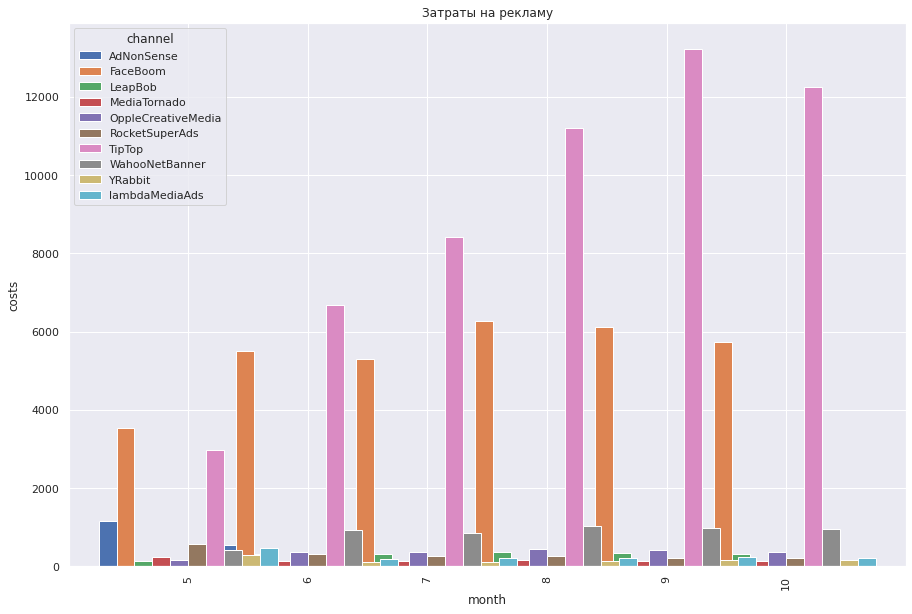

In [17]:
costs['month'] = pd.DatetimeIndex(costs['dt']).month 

display('Общие затраты:', round((costs['costs'].sum())))
(
    costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
    .plot (kind='bar', width=1.5)
)
plt.title('Затраты на рекламу')
plt.ylabel('costs')

plt.show()

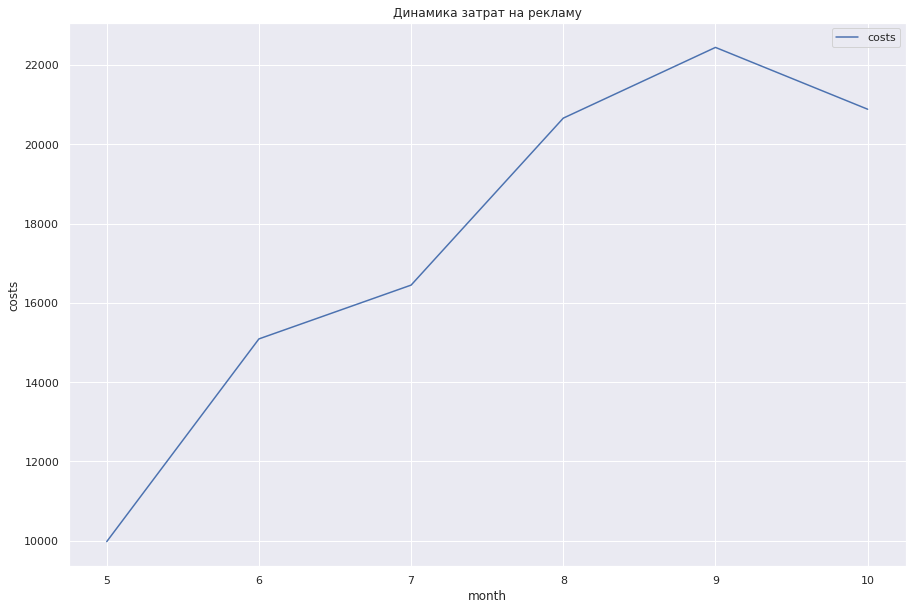

In [18]:
(
    costs.pivot_table(index='month', values='costs', aggfunc='sum')
    .plot (grid=True)
)
plt.title('Динамика затрат на рекламу')
plt.ylabel('costs')

plt.show()

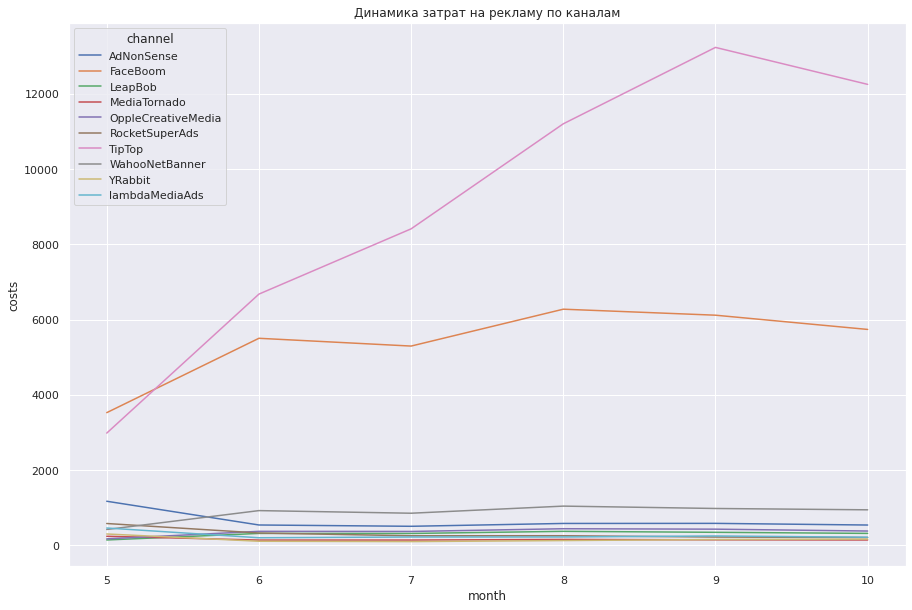

In [19]:
(
    costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
    .plot (grid=True)
)
plt.title('Динамика затрат на рекламу по каналам')
plt.ylabel('costs')

plt.show()

Сколько денег потратили? Всего / на каждый источник / по времени

**С мая по сентябрь траты на рекламу увеличивались, в октябре снижение.
На TipTop и FaceBoom больше всего трат, но и с них приходит максимальное кол-во платящих клиентов и доля платящих высокая. В любом случае стоит проанализировать канал TipTop, конечно он дает результаты, но FaceBoom все таки лучше по всем критериям**

'Cредний CAC на одного пользователя'

1.1274813239427588

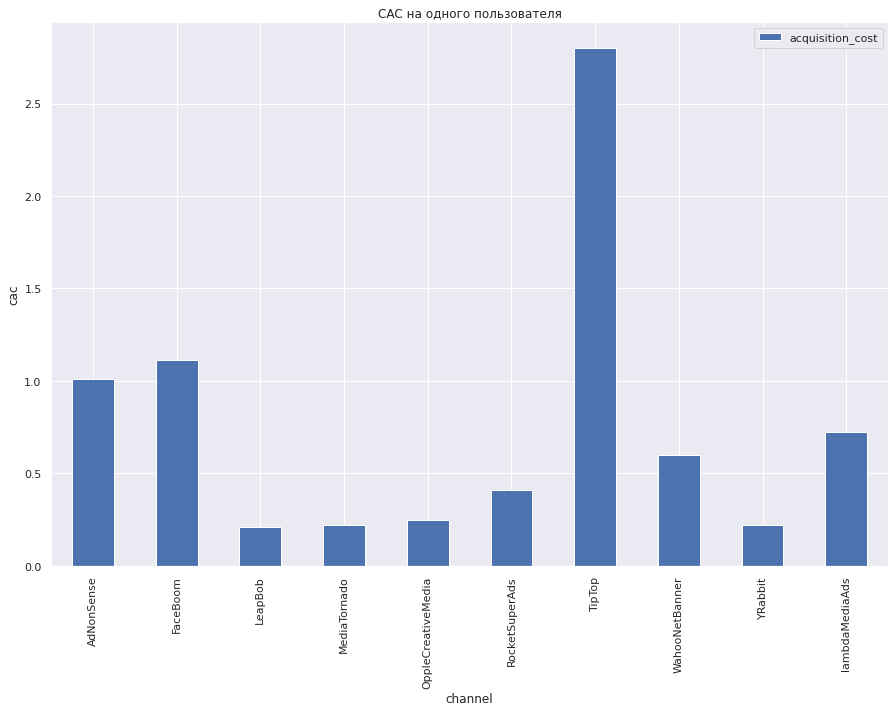

In [20]:
display('Cредний CAC на одного пользователя', profiles.query('acquisition_cost != 0')['acquisition_cost'].mean())

(
    profiles.query('acquisition_cost != 0')
    .pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
    .plot (kind='bar')
)
plt.title('CAC на одного пользователя')
plt.ylabel('cac')
plt.show()

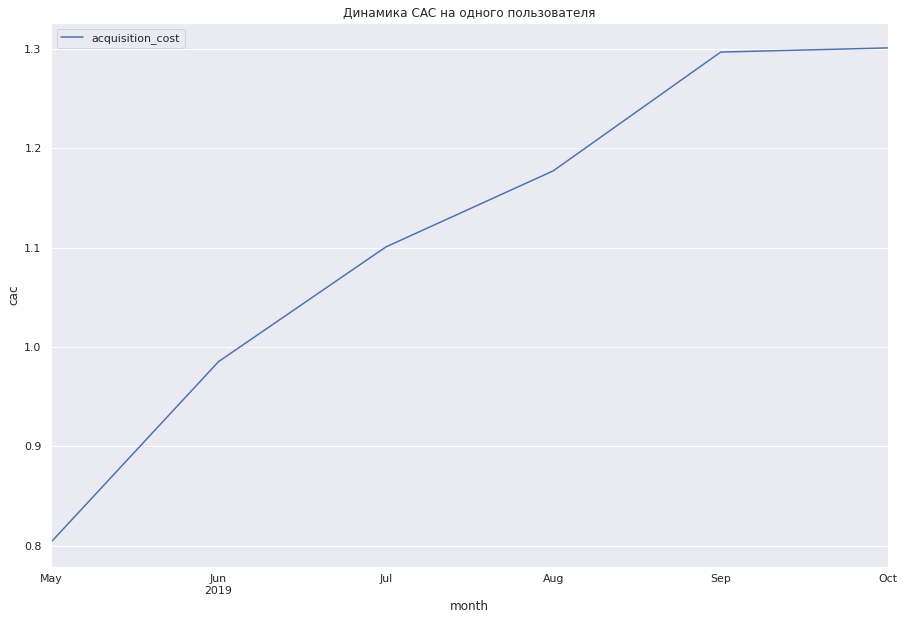

In [21]:
(
    profiles.query('acquisition_cost != 0')
    .pivot_table(index='month', values='acquisition_cost', aggfunc='mean')
    .plot (grid=True)
)
plt.title('Динамика CAC на одного пользователя')
plt.ylabel('cac')
plt.show()

Сколько в среднем стоило привлечение одного покупателя из каждого источника?

**В среднем привлечение одного покупателя стоило 1.127, самые дорогие пользователи из канала TipTop, FaceBoom, AdNonSens и lambdaMediaAds, стоит обратить внимание на lambdaMediaAds приносит мало пользователей, да еще дорогих. А вот WahooNetBanner поражает - приносит достаточно много платящих клиентов, при этом стоимость не велика** 

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

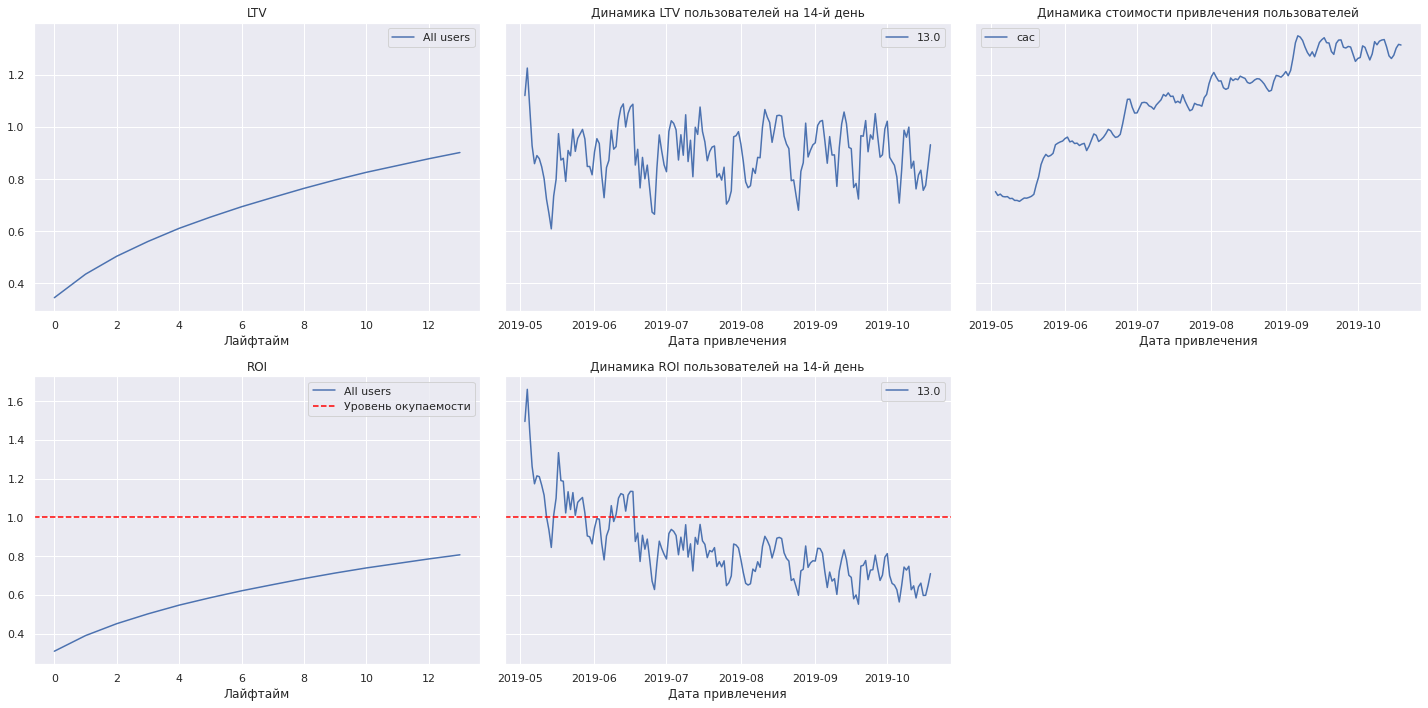

In [22]:
# постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

profiles = profiles.query('channel != "organic"')

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

days_num = (max_date - min_date).days
daily_costs = []
for index, values in costs.iterrows():
    channel_name = values['channel']
    channel_costs = values['costs']
    avg_channel_costs = channel_costs / days_num
    for i in range(days_num):
        current_day = min_date + timedelta(days=i)
        daily_costs += [[current_day, channel_name, avg_channel_costs]]
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
daily_costs['dt'] = daily_costs['dt'].dt.date

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

**Roi страдает надо понять в чем проблема**

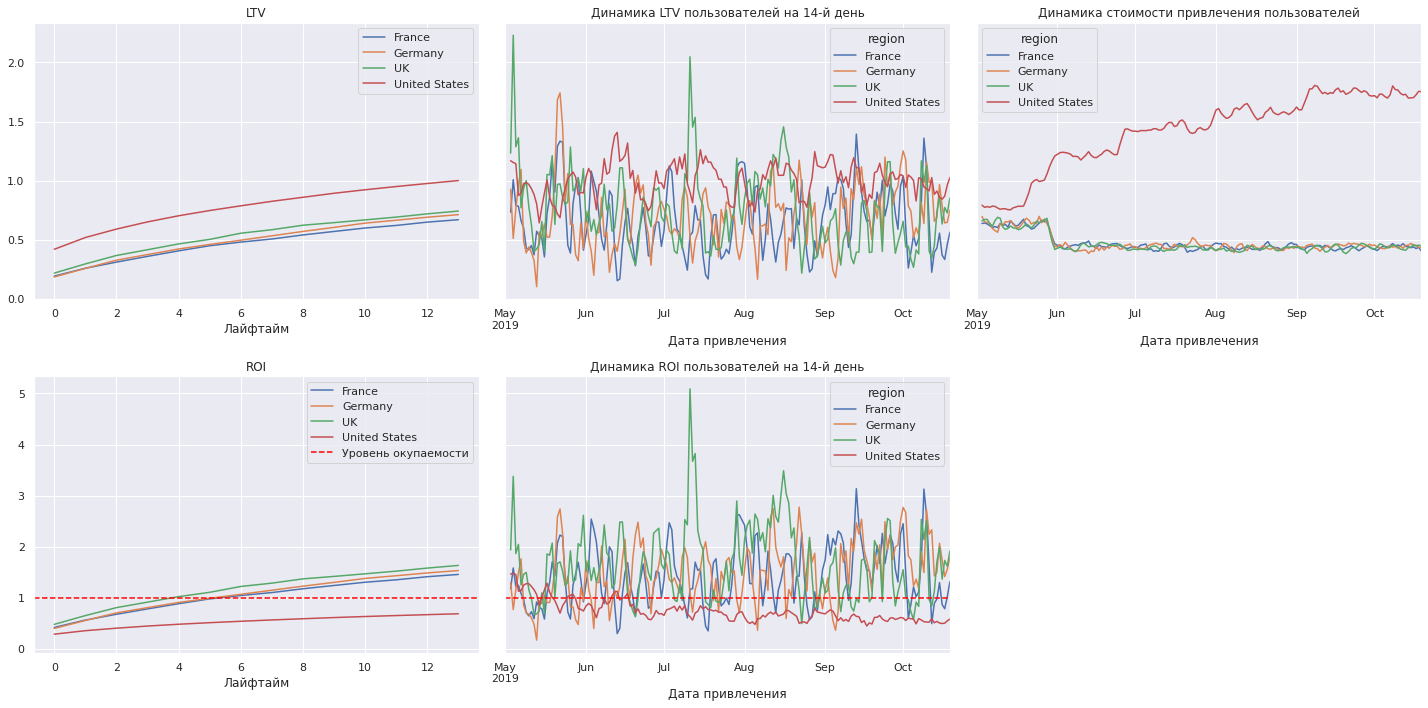

In [23]:
# проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

**Стабильные и окупаемые регионы UK и Germany, регион аутсайдер по финансовым метрикам (юнит экономика): в принципе не окупается и с каждым месяцам стоимость клиента растет, хотя приносит большинство клиентов - United States**

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

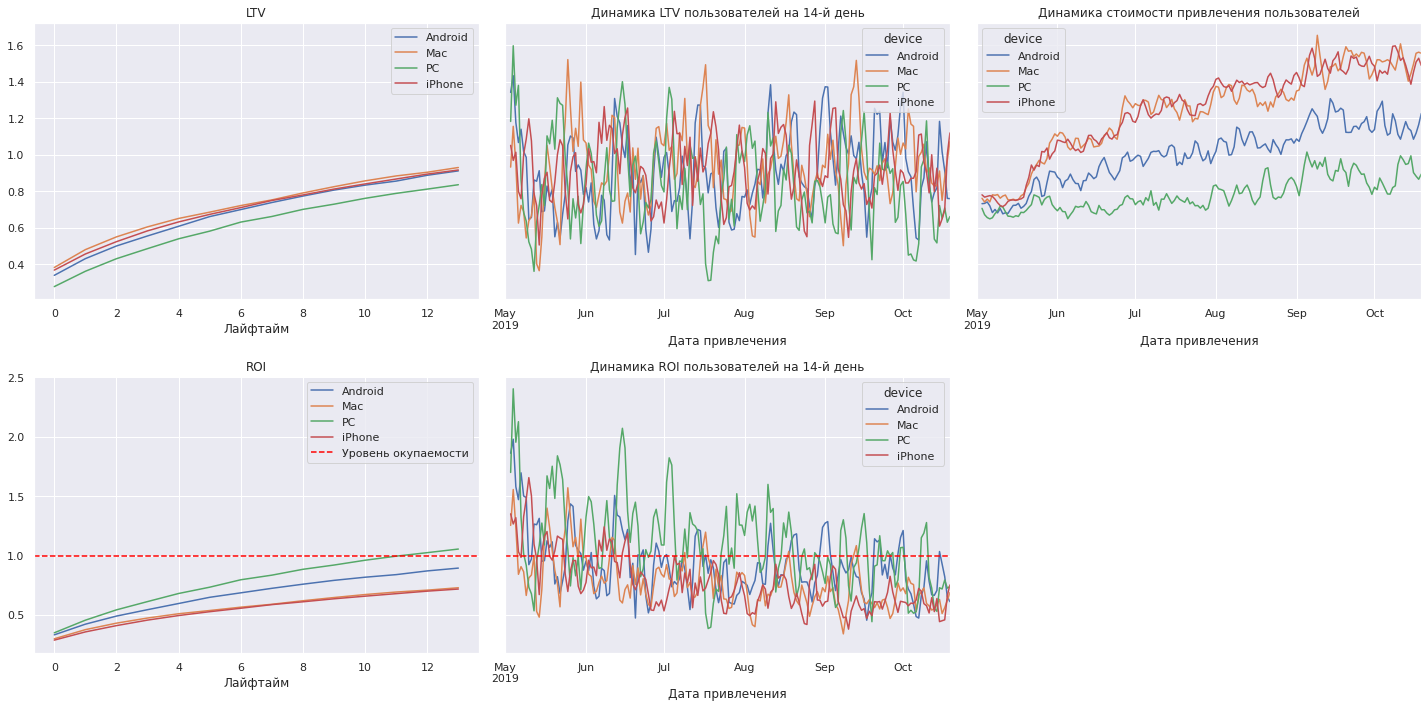

In [24]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

**Стоимость клиентов, которые приходят с Iphone и Mac выше из месяца в месяц в несколько раз чем иные устройства. Аналогичная картина по ROI - Iphone и Mac не окупаются, если посмотреть в динамике, то предыдущие месяца показывали более стабильные результаты, октябрь - самый провальный месяц**

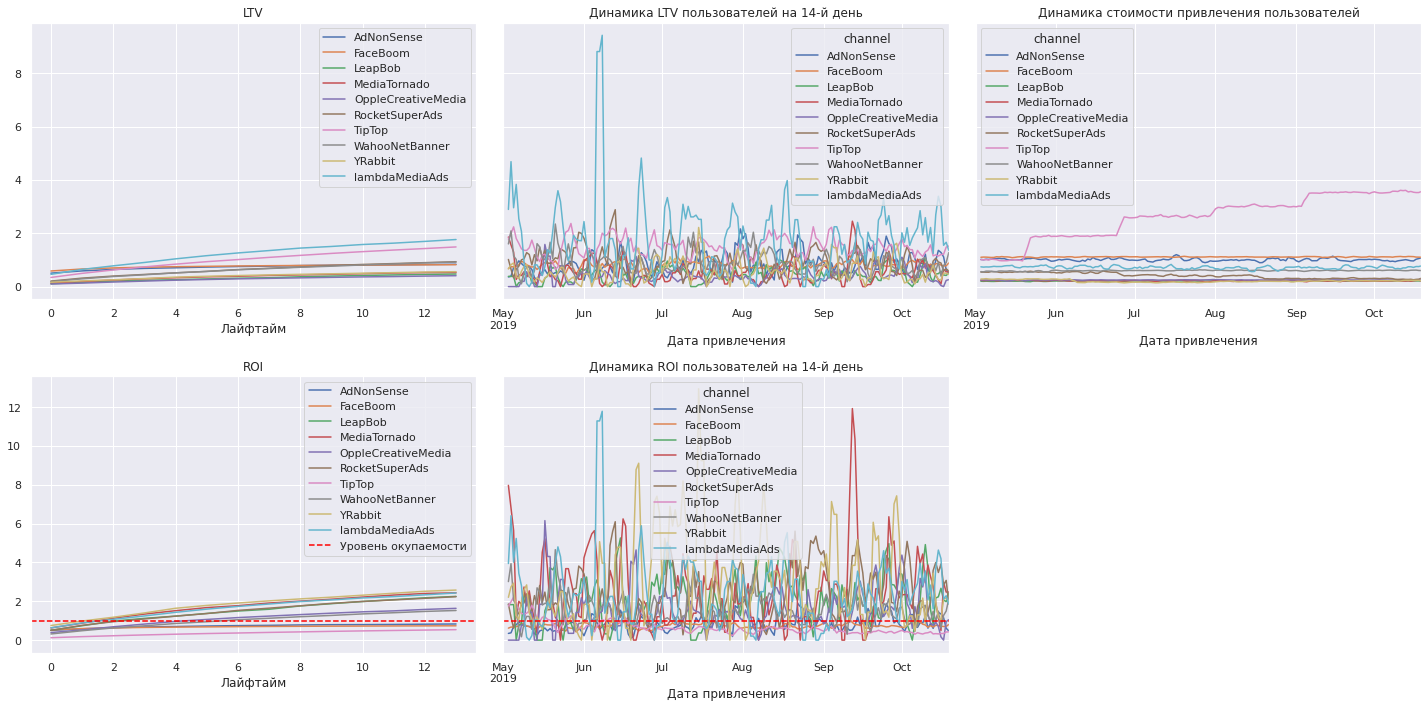

In [25]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

**Отказываемся от канала TipTop и начинаем следить на FaceBoom более плотно, ищем новые каналы для раскрутки**

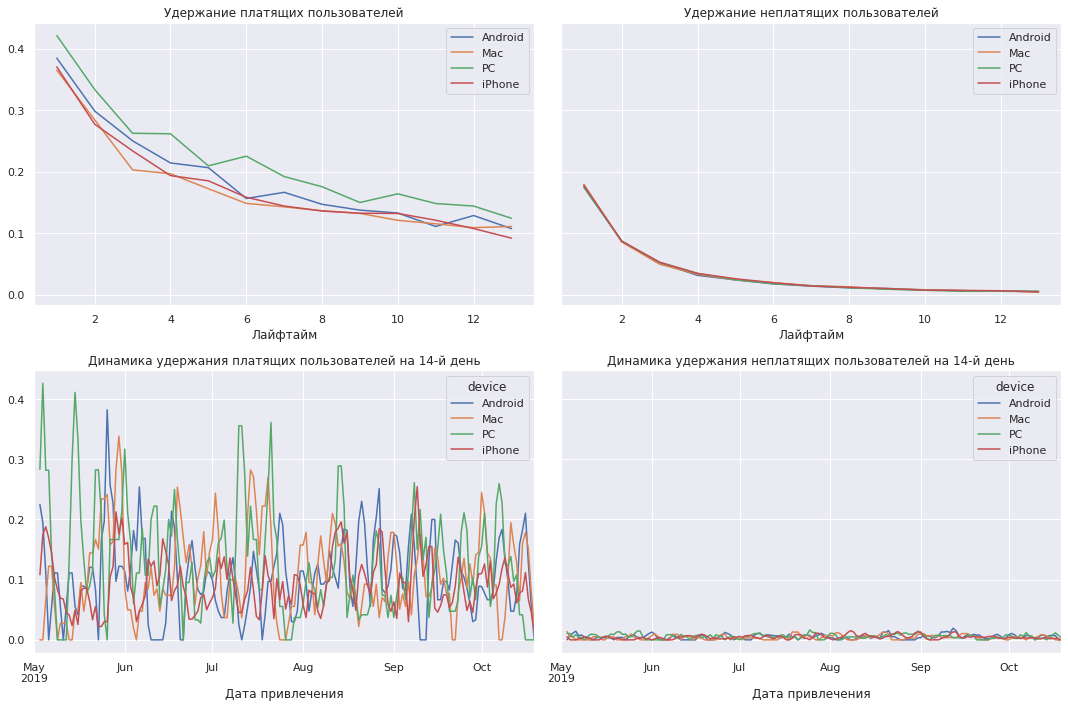

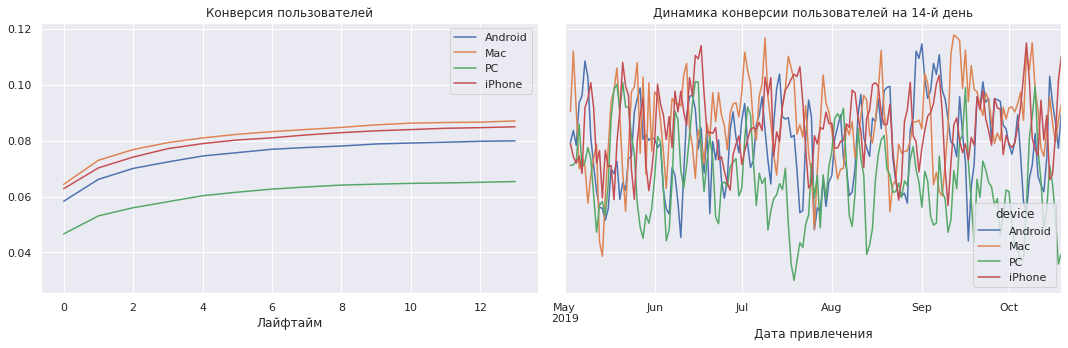

In [26]:
# постройте и изучите графики конверсии и удержания с разбивкой по устройствам

def plot_retention(retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()
    
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
    
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device'])
    
conversion_raw, conversion, conversion_history = get_conversion (profiles, orders, datetime(2019, 11, 1).date(), 14, 
                                                                 dimensions=['device'])
    
plot_retention (retention, retention_history, 14, window=3)
plot_conversion (conversion, conversion_history, 14, window=3)
    



**Когортный анализ показал, что с устройства РС приходят самые качественные клиенты, которые живут с нами долго, а вот c iPhone и Мас не очень хотят с нами оставаться, хотя конверсия у них высокая, стоит проанализировать приложение на наличие технических ошибок(верстка) на устройствах iPhone и Мас. Как и ранее замечено Android показывает себя стабильно хорошо (не забываем, что он больше всего развит в United States)**

### Проанализируйте окупаемость рекламы с разбивкой по странам

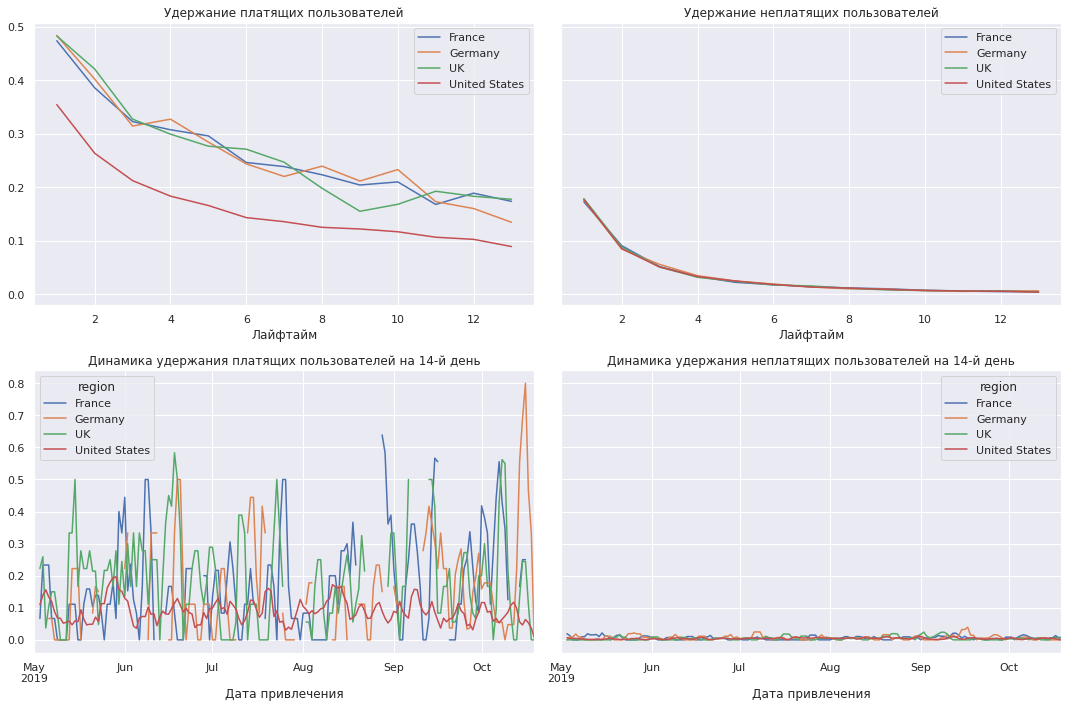

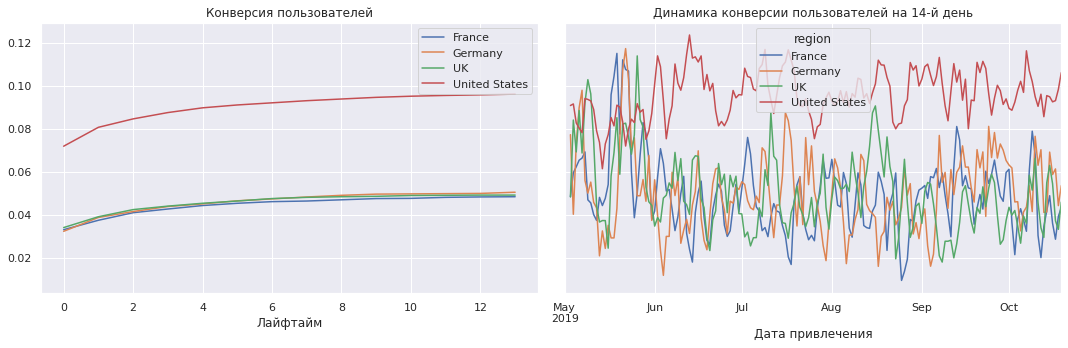

In [27]:
# постройте и изучите графики конверсии и удержания с разбивкой по странам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region'])
    
conversion_raw, conversion, conversion_history = get_conversion (profiles, orders, datetime(2019, 11, 1).date(), 14, 
                                                                 dimensions=['region'])
    
plot_retention (retention, retention_history, 14, window=3)
plot_conversion (conversion, conversion_history, 14, window=3)

**Вот мы почти до копались до истины - опять в аутсайдерах United States(удержание), хотя конверсия хорошая, скорей всего за счет устройства Android**

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

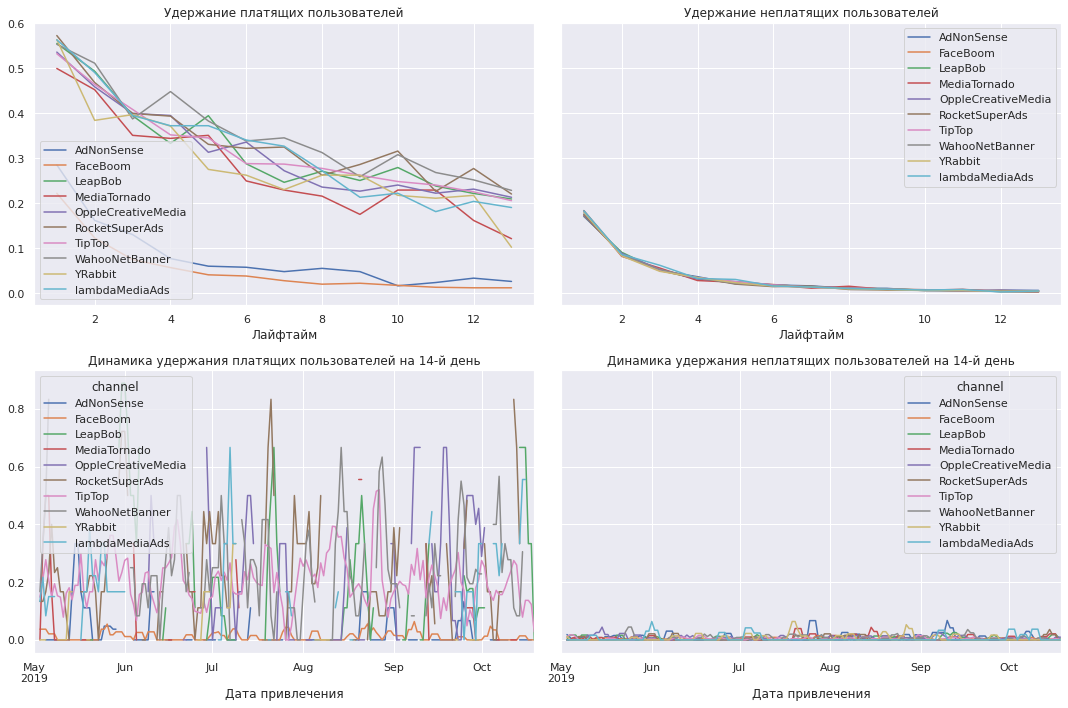

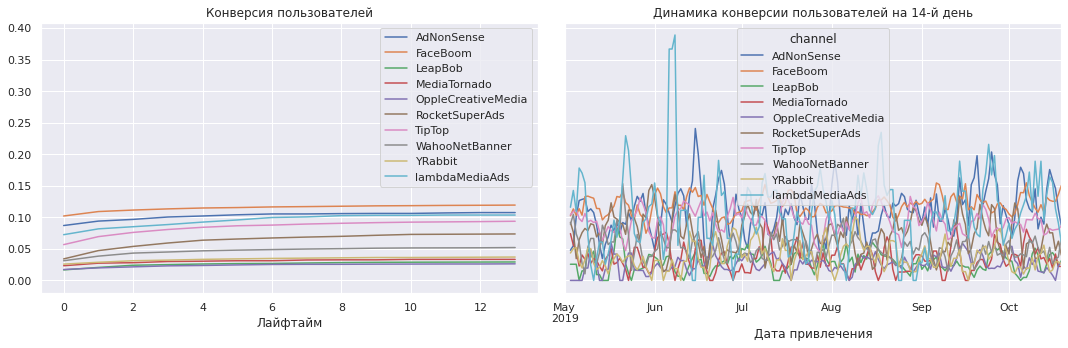

In [28]:
# постройте и изучите графики конверсии и удержания с разбивкой по каналам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])
    
conversion_raw, conversion, conversion_history = get_conversion (profiles, orders, datetime(2019, 11, 1).date(), 14, 
                                                                 dimensions=['channel'])
    
plot_retention (retention, retention_history, 14, window=3)
plot_conversion (conversion, conversion_history, 14, window=3)

**ХМ... странно, вроде с канала FaceBoom приходят достаточно хорошая доля конверсионных клиентов, но они не остаются дальше, а вот гипотеза, озвученная мной раньше, что стоит обратить внимание на канал WahooNetBanner подтверждается ценой и качеством клиента. TipTop ведут стабильно хорошо** 

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

**Причины неэффективности**:

1.Самый крупномасштабный регион - United States приносит убытки по всем показателям воронки, кроме привлечения

2.Проблема с устройствами iPhone и Mac при повторной покупки, а именно конверсия с этих устройств хорошая, но удержание - нет с учетом этого показатели САС и ROI не очень хорошие, а возможно, еще связано это с рекламой TipTop, на которую был потрачен не оправданный бюджет

3.Необходимо пересмотреть фокусы на рекламные компании, а также проанализировать текущие, которые приносят достаточно много пользователей

**Рекомендации**:

1.Для всех регионов - проверить функциональность приложения с устройства iPhone и Mac по всем параметрам: от входа до повторной покупки

2.Для все регионов - выделить бюджет на канал WahooNetBanner, lambdaMediaAds и Yrabbit, пересмотреть/проверить рекламные компании FaceBoom и TipTop, а именно проверить ожидание, которые в них озвучивают/акцию и реальность, а также на какую категорию реклама рассчитана

3.United States после отработки п1 и п2 скорей всего станет прибыльным